In [1737]:
import pandas as pd
import os
# import pyarrow
import matplotlib.pyplot as plt
import matplotlib
# from pyvis import network as net
import networkx as nx
import plotly.express as px
import seaborn as sns
import numpy as np
import math

# plt.style.use('ggplot')
pd.options.display.float_format = '{:20,.2f}'.format

In [1722]:
#make a list of all excel files
excels = [i for i in os.listdir('/Users/joshhawkins/Desktop/Treasury Course/Day One/Homework') if 'xlsx' in i]
excels

['Exhibit #07_2339696 Rachel Hale.xlsx',
 'Exhibit #09_2342298 Cochise Trucking.xlsx',
 "Exhibit #04_1235550 Juanita's Boutique.xlsx",
 'Exhibit #13_7899940 Jesus International Investments.xlsx',
 'Exhibit #06_2331210 Cochise Diverse Investments.xlsx',
 'Exhibit #08_2342296 Daisy Enterprises LLC.xlsx',
 'Exhibit #11_4567288 G & M Consulting.xlsx',
 'Exhibit #12_5679021 Bills Auto Sales.xlsx',
 'Exhibit #10_3454649 Moore Brothers Apple Growers.xlsx',
 'Exhibit #05_1235551 Douglas Import & Export.xlsx']

In [1723]:
def clean_transaction_data(path):
    #read in
    df = pd.read_excel(path, header=None)
    
    #only keep transaction rows
    for row in range(df.shape[0]): 
        for col in range(df.shape[1]):
            if 'Acct #' in str(df.iat[row,col]):
                account = str(df.iat[row,col]).split('# ')[1]
                bank = df.iat[row+1,col]
                business = df.iat[row+2,col]
                break
                
    #only keep transaction rows
    for row in range(df.shape[0]): 
        for col in range(df.shape[1]):
            if 'POC' in str(df.iat[row,col]):
                owner = str(df.iat[row,col]).split(': ')[1]
                break
                
    #only keep transaction rows
    for row in range(df.shape[0]): 
        for col in range(df.shape[1]):
            if df.iat[row,col] == 'Outgoing Wire or Bank to Bank Transfers or Withdrawls':
                row_start = row
                break
    df_required = df.loc[row_start+1:]

    #clean
    df_required.columns = ['Date', 'From Act#', 'From Bank', 'To Act#', 'To Bank', 'Amount', 'To_Location']
    df_required['Date'].fillna(method='ffill', inplace=True)
    df_required['To Act#'].fillna(method='ffill', inplace=True)
    df_required['To_Location'].fillna('', inplace=True)
    df_required = df_required.dropna(subset=['Date', 'From Act#'], axis=0)
    df_required = df_required[df_required.Date != 'Date'].reset_index(drop=True)
    df_required['From Act#'] = df_required['From Act#'].astype(str)
    df_required['To Act#'] = df_required['To Act#'].astype(str)
    df_required.columns.name = None
    
    #remove Monthly Total Withdrawls rows
    df_required = df_required[df_required.To_Location != 'Monthly Total Withdrawls'].reset_index(drop=True)
    
    #add in 'withdraw' or 'deposit'
    df_required['Account'] = str(account)
    df_required['type'] = 'deposit'
    df_required.loc[df_required['From Act#'].astype(str) == str(account), 'type'] = 'withdraw'
    
    #add in other account info
    df_required['Bank'] = str(bank)
    df_required['Business'] = str(business)
    df_required['Owner'] = str(owner)
    
    #logic for checks
    df_required.loc[(df_required['From Act#'].astype(str).str.len() == 4)
                    |(df_required['From Act#'].astype(str).str.len() == 5), 'type'] = 'withdraw' 
    df_required.loc[(df_required['From Act#'].astype(str).str.len() == 4)
                    |(df_required['From Act#'].astype(str).str.len() == 5), 'To Bank'] = df_required['From Bank']
    df_required.loc[(df_required['From Act#'].astype(str).str.len() == 4)
                    |(df_required['From Act#'].astype(str).str.len() == 5), 'From Bank'] = bank
    df_required.loc[(df_required['From Act#'].astype(str).str.len() == 4)
                    |(df_required['From Act#'].astype(str).str.len() == 5), 'To Act#'] = '(Check) '+df_required['To_Location']
    df_required.loc[(df_required['From Act#'].astype(str).str.len() == 4)
                    |(df_required['From Act#'].astype(str).str.len() == 5), 'From Act#'] = df_required['Account']
    
    return df_required


#concat processed runs
df = pd.concat([clean_transaction_data('/Users/joshhawkins/Desktop/Treasury Course/Day One/Homework/'+i) for i in excels]).reset_index(drop=True)
df


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,From Act#,From Bank,To Act#,To Bank,Amount,To_Location,Account,type,Bank,Business,Owner
0,2030-02-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale
1,2030-03-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale
2,2030-04-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale
3,2030-05-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,70000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale
4,2030-02-01 00:00:00,W4567288,WSFS Bank,BF2339696,Butterfield Bank,45000,,BF2339696,deposit,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale
...,...,...,...,...,...,...,...,...,...,...,...,...
688,2030-04-30 00:00:00,1235551,Wells Fargo Bank,(Check) Fuel,Good 2 Go Gas,45,Fuel,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine
689,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Payroll,Yasmine Badreddine,3000,Payroll,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine
690,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Rent & Utilities,Raul Zapata,400,Rent & Utilities,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine
691,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Mailing & Postage,Cash,650,Mailing & Postage,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine


In [1724]:
#Get Account Info

def get_account_data(path):
    #read in
    df = pd.read_excel(path, header=None)
    
    #only keep transaction rows
    for row in range(df.shape[0]): 
        for col in range(df.shape[1]):
            if 'Acct #' in str(df.iat[row,col]):
                account = str(df.iat[row,col]).split('# ')[1]
                bank = df.iat[row+1,col]
                business = df.iat[row+2,col]
                break
    
    #only keep transaction rows
    for row in range(df.shape[0]): 
        for col in range(df.shape[1]):
            if 'POC' in str(df.iat[row,col]):
                owner = str(df.iat[row,col]).split(': ')[1]
                break
    return pd.DataFrame({'Account':[account],
                         'Bank': [bank],
                         'Business': [business],
                         'Owner': [owner]})

#concat processed runs
account_df = pd.concat([get_account_data('/Users/joshhawkins/Desktop/Treasury Course/Day One/Homework/'+i) for i in excels]).reset_index(drop=True)

account_df['Full_Account'] = account_df['Bank']+','+account_df['Business']

#add in Divx
account_df = pd.concat([account_df, pd.DataFrame({'Account': ['Divx Computers'], 
                                                  'Owner': ['Divx Salvadore'],
                                                  'Full_Account':['Divx Computers']})]).reset_index(drop=True)

#account list
known_accounts = account_df.Account.unique().tolist()
account_df


,Account,Bank,Business,Owner,Full_Account
0,BF2339696,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Butterfield Bank,Rachel Hale Distribution LLC"
1,2342298,Washington Federal,Cochise Trucking,Raul Zapata,"Washington Federal,Cochise Trucking"
2,1235550,Wells Fargo Bank,Juanita's Boutique,Yasmine Badreddine or Fred Smith,"Wells Fargo Bank,Juanita's Boutique"
3,7899940,Bueno Cambio Exchange,Jesus International Investments,Luis Jesus Cruz Vega Cell Phone,"Bueno Cambio Exchange,Jesus International Inve..."
4,CF2331210,First Caribbean International Bank,Cochise Diverse Investments LLC,Jasmin Zapata,"First Caribbean International Bank,Cochise Div..."
5,2342296,Washington Federal,Daisy Enterprises LLC,Juanita de Espinosa,"Washington Federal,Daisy Enterprises LLC"
6,W4567288,WSFS Bank,G & M Consultinig LLC,Fred Smith,"WSFS Bank,G & M Consultinig LLC"
7,K5679021,Key Bank,Bill's Auto Sales,W. Riley,"Key Bank,Bill's Auto Sales"
8,B3454649,Banner Bank,Moore Brothers Apple Growers,Randy Moore,"Banner Bank,Moore Brothers Apple Growers"
9,1235551,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,"Wells Fargo Bank,Douglas Import & Export Company"


In [1725]:
account_df.loc[account_df['Account'] == 'BF2339696']['Full_Account']

0    Butterfield Bank,Rachel Hale Distribution LLC
Name: Full_Account, dtype: object

In [1726]:
known_accounts

['BF2339696',
 '2342298',
 '1235550',
 '7899940',
 'CF2331210',
 '2342296',
 'W4567288',
 'K5679021',
 'B3454649',
 '1235551',
 'Divx Computers']

In [1727]:
#optimize memory using cats

#renames
new_names = {'From Act#': 'From_Acct',
            'To Act#': 'To_Acct',
            'From Bank': 'From_Bank',
            'To Bank': 'To_Bank'}
df.rename(columns=new_names, inplace=True)

#Get full 'to' using join
to_join = account_df[['Account', 'Full_Account']]\
                        .rename(columns={'Account':'To_Acct', 'Full_Account': 'Full_To_Account'}).copy()
df = df.merge(to_join, on=['To_Acct'], how='left')
df['Full_To_Account'] = df.Full_To_Account.fillna(df['To_Acct'].astype(str)  +': '+df['To_Bank'].astype(str))

#Get full 'from' using join
from_join = account_df[['Account', 'Full_Account']]\
                        .rename(columns={'Account':'From_Acct', 'Full_Account': 'Full_From_Account'}).copy()
df = df.merge(from_join, on=['From_Acct'], how='left')
df['Full_From_Account'] = df.Full_From_Account.fillna(df['From_Acct'].astype(str)  +': '+df['From_Bank'].astype(str))

#RESTORE PAYPAL ACCOUNT INFO FOR Juanita's Boutique and Divx

df.loc[df.To_Location == "Juanita's Boutiques", 'To_Acct'] = '1235550'
df.loc[df.To_Location == "Juanita's Boutiques", 'Full_To_Account'] = "Wells Fargo Bank,Juanita's Boutique"

df.loc[df.To_Location == "Divx Computers", 'To_Acct'] = 'Divx Computers'
df.loc[df.To_Location == "Divx Computers", 'Full_To_Account'] = "Divx Computers"

df
                        

# # #categories for everything but dates and amounts
# # def categorical(x):
# #     df[x] = df[x].astype('category')
# # [categorical(i) for i in df.columns.tolist() if i not in ['Date', 'Amount']]

# df

,Date,From_Acct,From_Bank,To_Acct,To_Bank,Amount,To_Location,Account,type,Bank,Business,Owner,Full_To_Account,Full_From_Account
0,2030-02-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC"
1,2030-03-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC"
2,2030-04-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC"
3,2030-05-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,70000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC"
4,2030-02-01 00:00:00,W4567288,WSFS Bank,BF2339696,Butterfield Bank,45000,,BF2339696,deposit,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Butterfield Bank,Rachel Hale Distribution LLC","WSFS Bank,G & M Consultinig LLC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2030-04-30 00:00:00,1235551,Wells Fargo Bank,(Check) Fuel,Good 2 Go Gas,45,Fuel,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Fuel: Good 2 Go Gas,"Wells Fargo Bank,Douglas Import & Export Company"
689,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Payroll,Yasmine Badreddine,3000,Payroll,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Payroll: Yasmine Badreddine,"Wells Fargo Bank,Douglas Import & Export Company"
690,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Rent & Utilities,Raul Zapata,400,Rent & Utilities,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Rent & Utilities: Raul Zapata,"Wells Fargo Bank,Douglas Import & Export Company"
691,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Mailing & Postage,Cash,650,Mailing & Postage,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Mailing & Postage: Cash,"Wells Fargo Bank,Douglas Import & Export Company"


In [1728]:
df.Full_From_Account.unique().tolist()

# df[df.To_Acct == "Divx Computers"]

['Butterfield Bank,Rachel Hale Distribution LLC',
 'WSFS Bank,G & M Consultinig LLC',
 "Wells Fargo Bank,Juanita's Boutique",
 'Washington Federal,Cochise Trucking',
 'Wells Fargo Bank,Douglas Import & Export Company',
 'ATM Dpt: Cash',
 'Auto WD: PayPal',
 '9785431: Central City',
 '9871652: Citi-Corp',
 '8764565: Johnson Bank',
 '8760256: American West',
 '9878167: U.S. Bank',
 '9676565: M&T Bank',
 '7873917: Chase',
 '8762891: Hefty Bank',
 '7890150: Leeds Bank',
 '9871745: Sun Trust',
 '8762515: Optical Bank',
 'ATM Dpt: Visa',
 'ATM Dpt: Master Card',
 'Bueno Cambio Exchange,Jesus International Investments',
 'First Caribbean International Bank,Cochise Diverse Investments LLC',
 "Key Bank,Bill's Auto Sales",
 'Washington Federal,Daisy Enterprises LLC',
 'Banner Bank,Moore Brothers Apple Growers']

In [1729]:
#SIMPLIFY ACCOUNTS AND MAKE 'NETWORK DF'

network_df = df.copy()

#Rename for '(Check)'
network_df.loc[network_df.Full_To_Account.str.contains('(Check)'), 'Full_To_Account'] = \
    "Check ->"+network_df.Full_To_Account.str.split(':').str[1]

network_df.loc[network_df.Full_To_Account.str.lower().str.contains('x-'), 'Full_To_Account'] = \
    "Check ->"+network_df.Full_To_Account.str.split(':').str[1]

network_df['Full_To_Account'] = network_df['Full_To_Account'].str.replace('Visa', 'VISA').str.strip()


#Rename for '(Check)'
network_df.loc[network_df.Full_From_Account.str.contains('ATM'), 'Full_From_Account'] = 'ATM Deposit'

network_df.Full_To_Account.unique().tolist()

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/2376961453.py:6: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



['Bueno Cambio Exchange,Jesus International Investments',
 'Butterfield Bank,Rachel Hale Distribution LLC',
 'Auto WD: Flex Wage',
 'Dir Pay: Shell Oil',
 'Auto WD: State Farm',
 'Debit: Wells Fargo',
 'Debit: AZ State Credit U',
 'Debit: Staples',
 'Debit: Shell Oil',
 '98776544: Scottsdale Credit',
 'Debit: Tacos Plumbing',
 "Debit: Tom's Towing",
 'Washington Federal,Cochise Trucking',
 "Wells Fargo Bank,Juanita's Boutique",
 'Check -> VISA',
 'WD: Cash/Pesos',
 'First Caribbean International Bank,Cochise Diverse Investments LLC',
 'Washington Federal,Daisy Enterprises LLC',
 'WSFS Bank,G & M Consultinig LLC',
 'Check -> American Express',
 "Key Bank,Bill's Auto Sales",
 'Check -> Butterfield Bank',
 'Banner Bank,Moore Brothers Apple Growers',
 'Auto WD: PayPal',
 'Divx Computers',
 'Wells Fargo Bank,Douglas Import & Export Company',
 '1235552: Wells Fargo Bank',
 'Check -> Yasmine Badreddine',
 'Check -> Raul Zapata',
 'Check -> Cash',
 'Check -> Good 2 Go Gas']

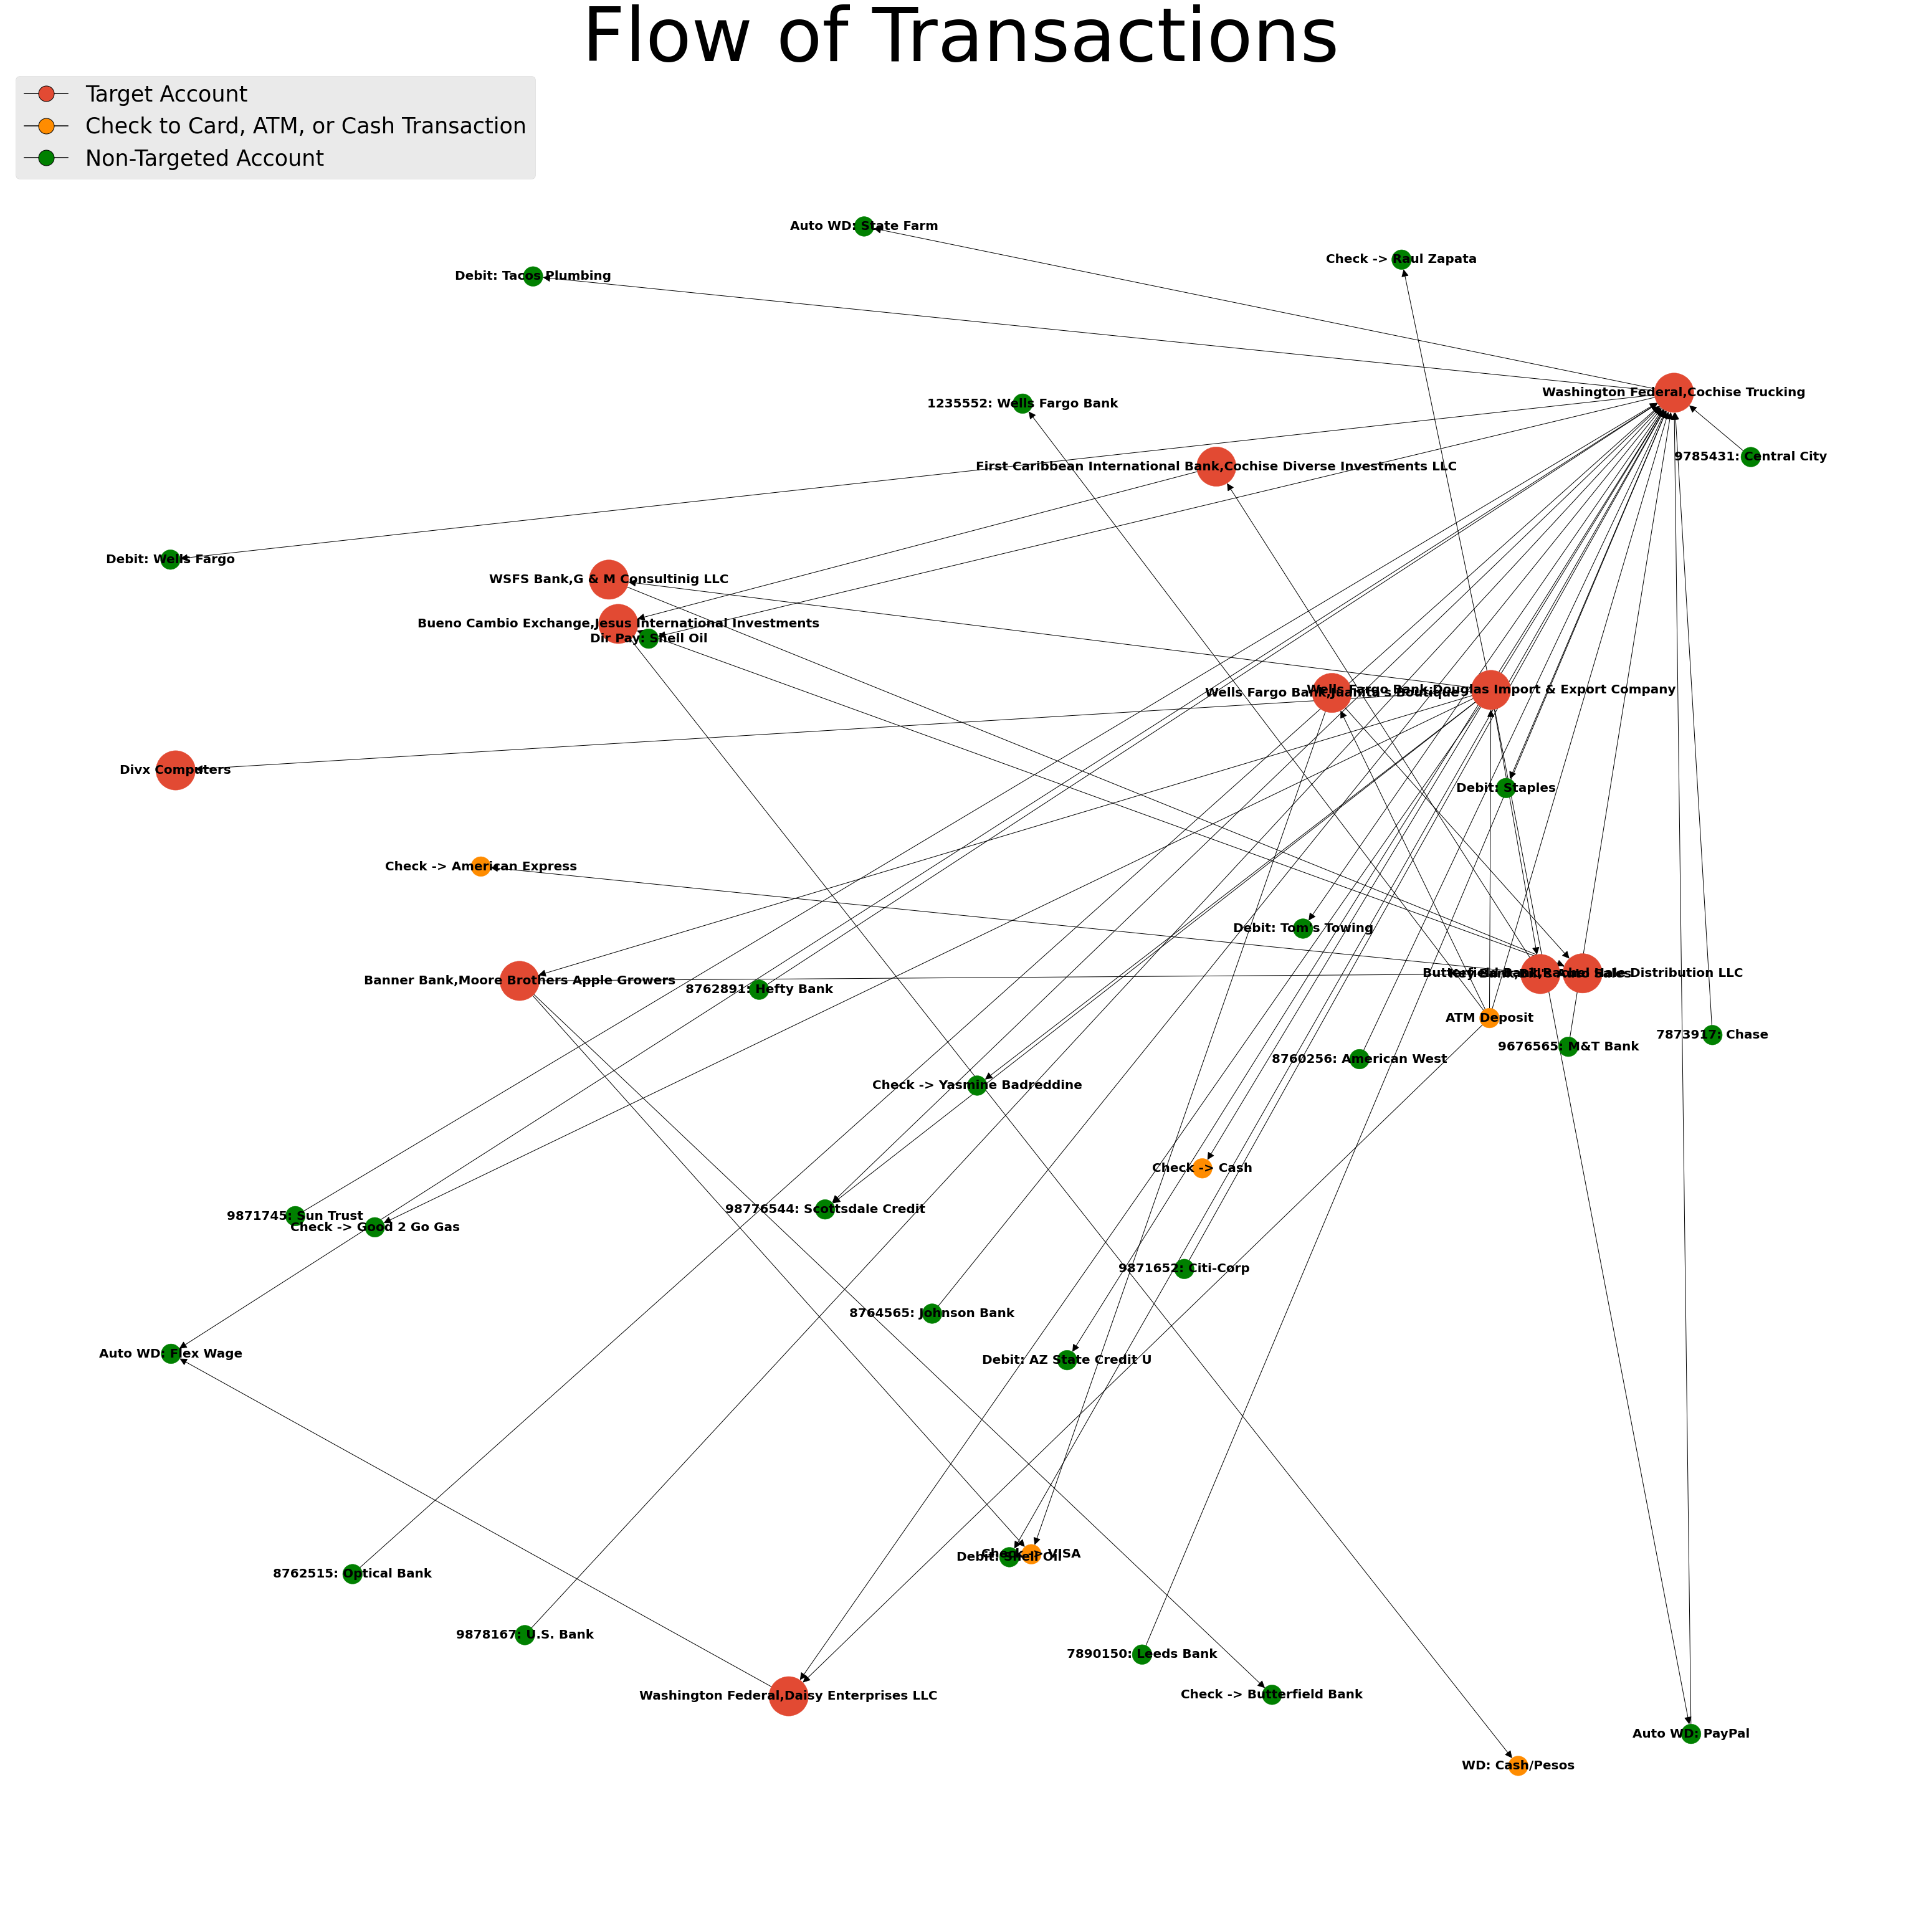

In [1730]:
#DIRECTIONAL NETWORK GRAPH

fig, ax = plt.subplots(figsize=(55,55))

#concat
custom_df = pd.concat([
    network_df[['Full_From_Account', 'From_Acct']].rename(columns={'Full_From_Account': 'ID'}).drop_duplicates(),
    network_df[['Full_To_Account', 'To_Acct']].rename(columns={'Full_To_Account': 'ID'}).drop_duplicates()
]).drop_duplicates().reset_index(drop=True)

#set types 'tracked' vs. 'not tracked'
custom_df['type'] = 'not tracked'
custom_df.loc[(custom_df.From_Acct.isin(known_accounts)), 'type'] = 'tracked'
custom_df.loc[(custom_df.To_Acct.isin(known_accounts)), 'type'] = 'tracked'

#mask transactions
custom_df.loc[custom_df.ID == 'ATM Deposit', 'type'] = 'mask'
custom_df.loc[custom_df.ID == 'Check -> VISA', 'type'] = 'mask'
custom_df.loc[custom_df.ID == 'Check -> Cash', 'type'] = 'mask'
custom_df.loc[custom_df.ID == 'Check -> American Express', 'type'] = 'mask'
custom_df.loc[custom_df.ID == 'WD: Cash/Pesos', 'type'] = 'mask'



custom_df

custom_df = custom_df[['ID', 'type']].drop_duplicates().reset_index(drop=True)
custom_df

network_df['Full_From_Account'] = network_df['Full_From_Account'].astype(str)
network_df['Full_To_Account'] = network_df['Full_To_Account'].astype(str)

#create 'Total_Exchanged' Field

network_df['Total_Exchanged'] = network_df.groupby(['Full_To_Account', 'Full_From_Account'])['Amount'].transform(lambda x: int(x.sum()))
network_df = network_df[['Full_From_Account', 'Full_To_Account', 'Total_Exchanged']].drop_duplicates().reset_index(drop=True)
network_df


# network_df.Full_From_Account.unique().tolist(), network_df.Full_To_Account.unique().tolist()

G = nx.from_pandas_edgelist(network_df, 'Full_From_Account', 'Full_To_Account', edge_attr='Total_Exchanged', create_using=nx.MultiDiGraph())
network_df

#set Nodes to IDs
# Make types into categories
carac = custom_df.set_index('ID')
carac

carac = carac.reindex(G.nodes())
carac

carac['type'] = pd.Categorical(carac['type'])
carac['type'].cat.codes

# Specify colors
cmap = matplotlib.colors.ListedColormap(['darkorange', 'green', 'C0'])

# Set node sizes
node_sizes = [4000 if entry == 'tracked' else 1000 for entry in carac.type]

# # Draw graph
# nx.draw(G, with_labels=True, node_color=carac['type'].cat.codes, cmap=cmap, 
#         node_size=node_sizes)

# # # # Draw graph
# nx.draw_shell(G, with_labels=True, font_size=20, node_color=carac['type'].cat.codes, cmap=cmap,  
#         node_size=node_sizes)

# # # Draw graph
edge_labels = nx.get_edge_attributes(G, "Total_Exchanged")
nx.draw_random(G, with_labels=True, font_size=20, font_weight="bold", node_color=carac['type'].cat.codes, cmap=cmap, 
        node_size=node_sizes, arrowsize=25)


# edge_labels = nx.get_edge_attributes(G, "Total_Exchanged")
# pos = nx.random_layout(G)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
# # nx.draw_networkx_edges(G, pos=pos, edgelist=edge_labels, #node_color=carac['type'].cat.codes, cmap=cmap, 
# #         node_size=node_sizes)


# # # # # Draw graph
# nx.draw_spring(G, with_labels=True, font_size=20, node_color=carac['type'].cat.codes, cmap=cmap, 
#         node_size=node_sizes)

# # # Draw graph
# nx.draw_spectral(G, with_labels=True, node_color=carac['type'].cat.codes, cmap=cmap, 
#         node_size=node_sizes)

# # nx.draw_networkx(G)

#LEGEND
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='black', markerfacecolor='C0', label='Target Account', markersize=25),
                   Line2D([0], [0], marker='o', color='black', markerfacecolor='darkorange', label='Check to Card, ATM, or Cash Transaction', markersize=25),
                   Line2D([0], [0], marker='o', color='black', markerfacecolor='green', label='Non-Targeted Account', markersize=25)]
ax.legend(handles=legend_elements, loc='upper left', prop={'size': 35})

plt.title('Flow of Transactions', size=120)

 
plt.show()

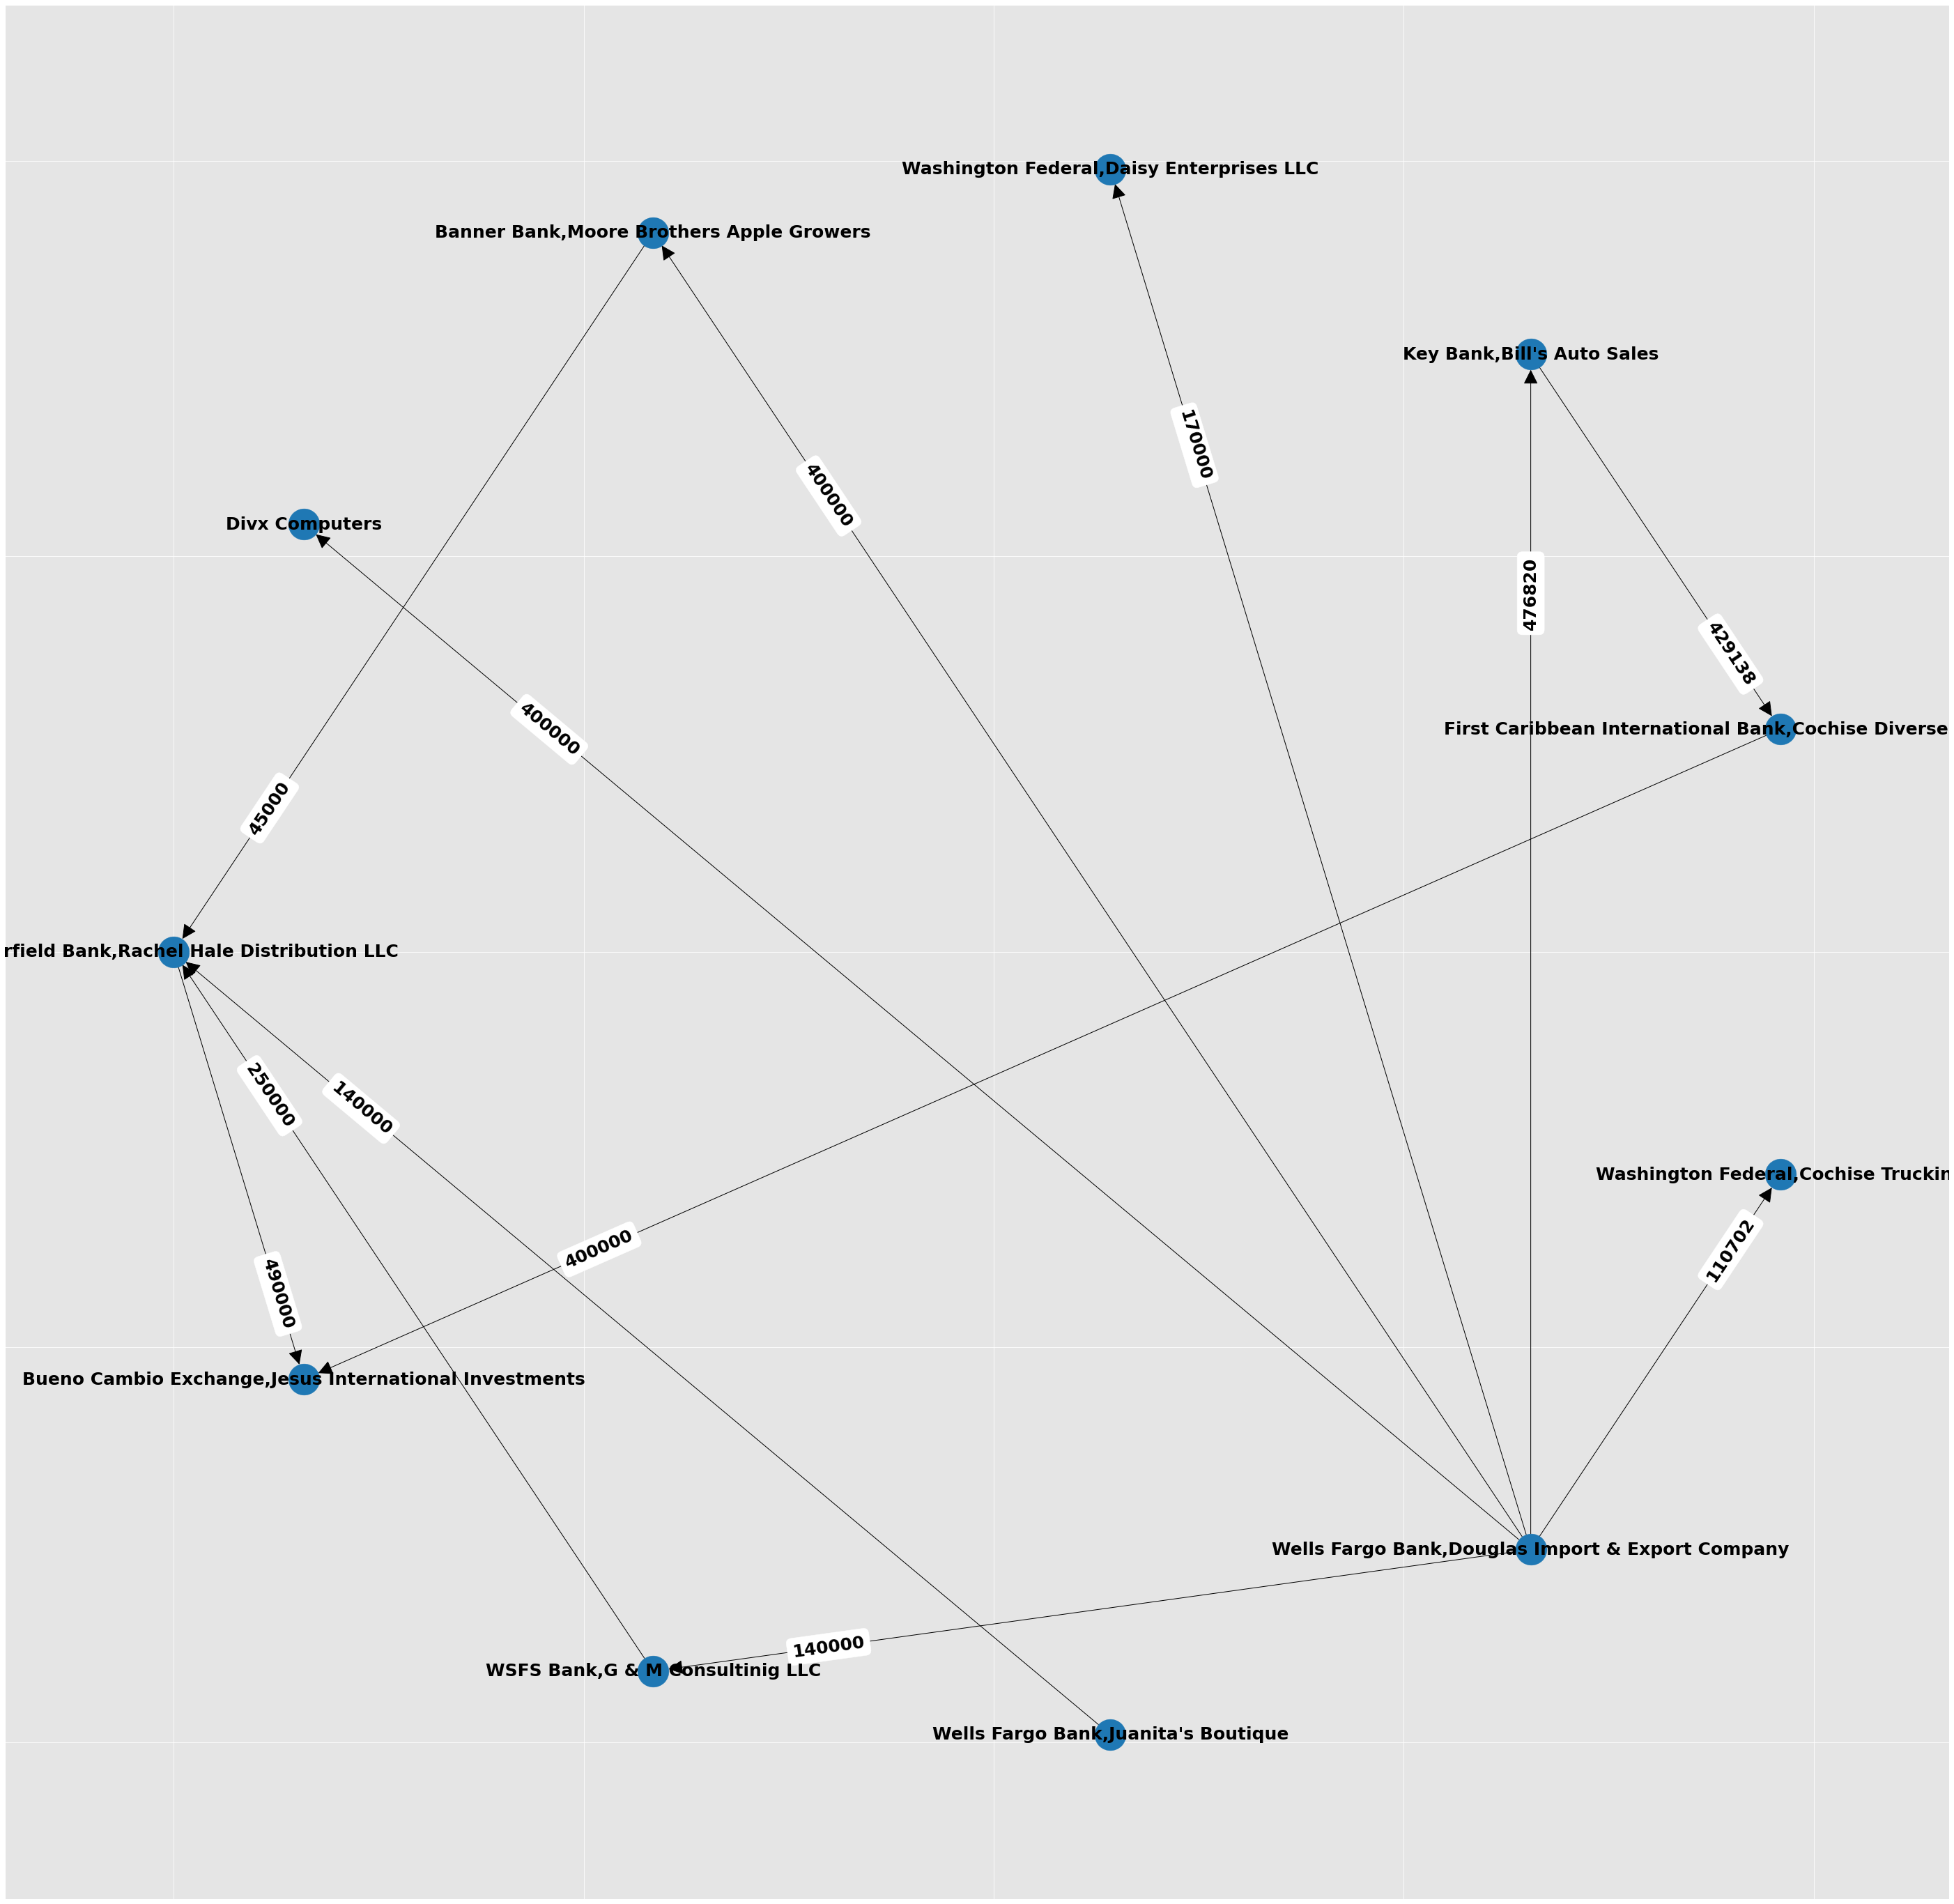

In [1731]:
network_df_2 = network_df.loc[(network_df['Full_From_Account'].isin(account_df.Full_Account.unique().tolist()))&\
         (network_df['Full_To_Account'].isin(account_df.Full_Account.unique().tolist()))       ]
network_df_2


fig, ax = plt.subplots(figsize=(50,50))
G = nx.from_pandas_edgelist(network_df_2, 'Full_From_Account', 'Full_To_Account', edge_attr='Total_Exchanged', create_using=nx.MultiDiGraph())



# # # Draw graph, 
pos = nx.shell_layout(G)
# edge_labels = nx.get_edge_attributes(G, "Total_Exchanged")

edge_labels=dict([((u,v,),d['Total_Exchanged'])
             for u,v,d in G.edges(data=True)])

nx.draw_networkx(G, pos, with_labels=True, font_size=25, font_weight="bold",
        node_size=2000, arrowsize=45)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels=edge_labels, label_pos=.2, font_size=25, font_weight="bold")


 
plt.show()

In [1714]:
#TTIMESERIES BALANCE ANALYSIS

#Get Totals
amount_df = df.copy()
amount_df['Month'] = amount_df['Date'].astype(str).str.split('-').str[1]
amount_df['Entity'] = amount_df['Business']+': '+amount_df['Owner']
amount_df['Actual'] = amount_df['Amount'].astype(float)
amount_df.loc[amount_df.type == 'withdraw', 'Actual'] = amount_df['Actual'] * (-1)
amount_df['Monthly_Total_USD'] = amount_df.groupby(['Business', 'type', 'Month'])['Actual'].transform(lambda x: x.sum())



#Label Methods
amount_df['Method'] = 'Bank to Bank'

#Checks
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Acct'].str.lower().str.contains('check')), 'Method'] = 'Check'
amount_df.loc[(amount_df['type'] == 'deposit')&(amount_df['From_Acct'].str.lower().str.contains('check')), 'Method'] = 'Check'

#ATM
amount_df.loc[(amount_df['type'] == 'deposit')&(amount_df['From_Acct'].str.lower().str.contains('atm')), 'Method'] = 'ATM'

#PayPal
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Bank'].str.lower().str.contains('paypal')), 'Method'] = 'PayPal'
amount_df.loc[(amount_df['type'] == 'deposit')&(amount_df['From_Bank'].str.lower().str.contains('paypal')), 'Method'] = 'PayPal'

#Debit/Wage Card
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Acct'].str.lower().str.contains('auto wd'))&\
    (amount_df['Method']!= 'PayPal'), 'Method'] = 'Debit/Wage Card'
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Location'].str.lower().str.contains('transfer to debit card')), 'Method'] = 'Debit/Wage Card'

#Debit/Direct Pay
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Acct'].str.lower().str.contains('dir pay')), 'Method'] = 'Debit/Direct Pay'
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Acct'].str.lower().str.contains('debit')), 'Method'] = 'Debit/Direct Pay'
amount_df.loc[(amount_df['type'] == 'withdraw')&(amount_df['To_Location'].str.lower().str.contains('insurance')), 'Method'] = 'Debit/Direct Pay'



#Create transaction monthly total dataframe
graph_df = amount_df.loc[amount_df.Monthly_Total_USD < 0]\
    [['Business', 'Month', 'Monthly_Total_USD']]\
        .rename(columns={'Monthly_Total_USD':'Total_Withdraw'}).merge(
        amount_df.loc[amount_df.Monthly_Total_USD > 0]\
    [['Business', 'Month', 'Monthly_Total_USD']]\
        .rename(columns={'Monthly_Total_USD':'Total_Deposit'}),
    how='outer', on=['Business', 'Month']).fillna(0).drop_duplicates().reset_index(drop=True)
graph_df['Monthly_Difference'] = graph_df['Total_Deposit'] + graph_df['Total_Withdraw']




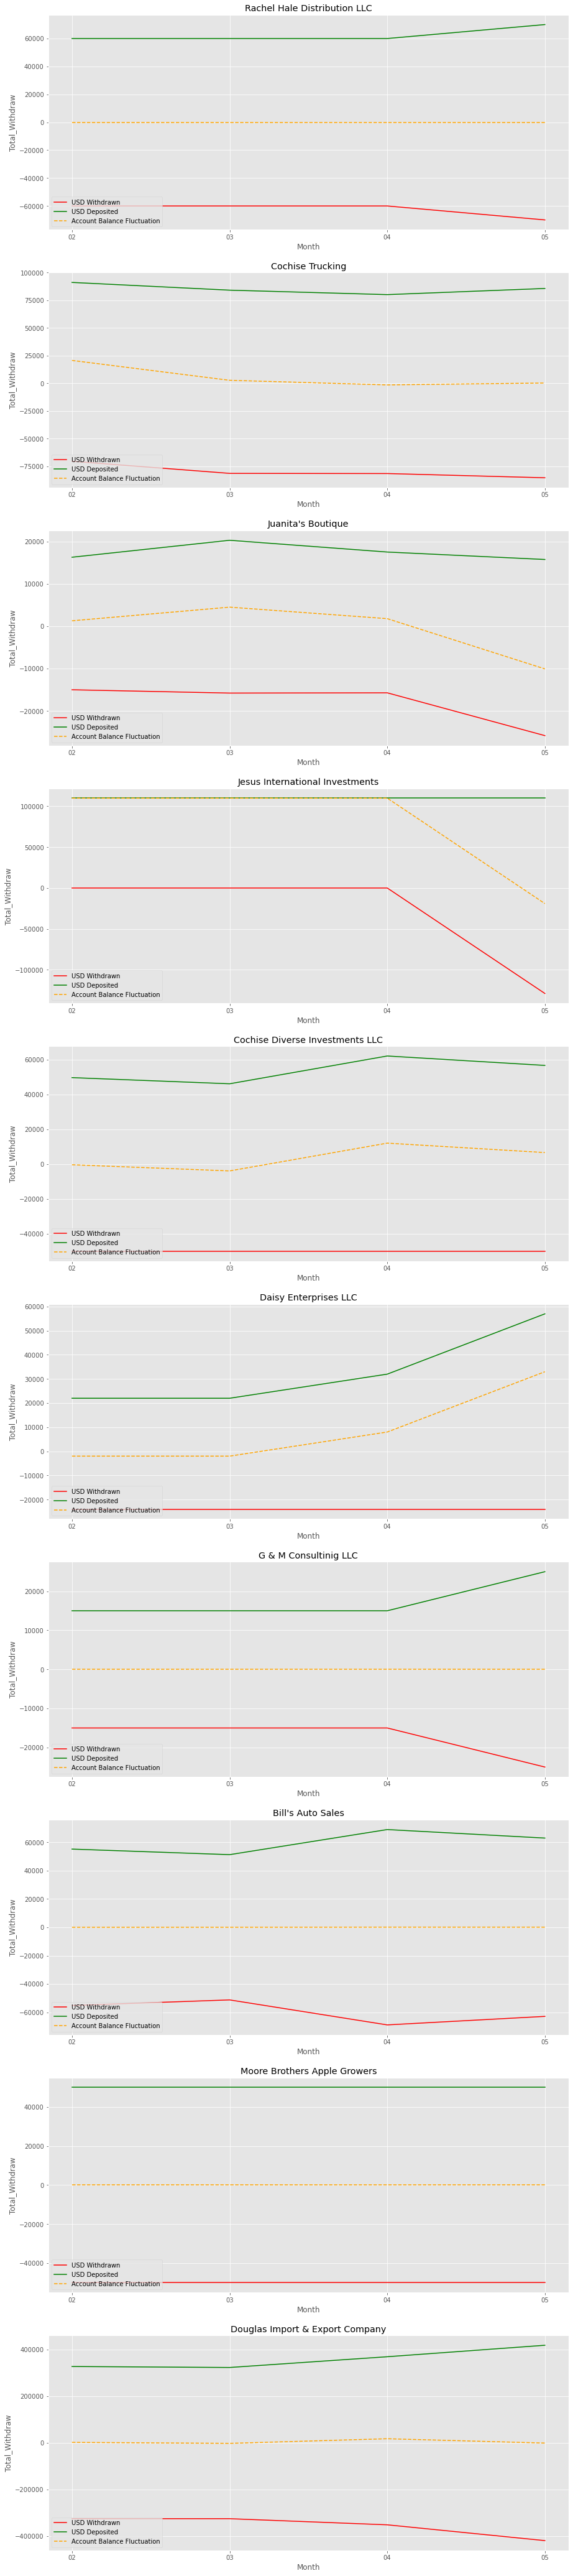

In [1715]:
#GRAPH 
business_list = amount_df.Business.unique().tolist()

fig, ax = plt.subplots(len(business_list), 1, figsize=(15,75))


palette = sns.color_palette("hls", 2)
for i in range(len(business_list)):
    sns.lineplot(
        data=graph_df[graph_df.Business == business_list[i]].sort_values('Month', ascending=True), color="red", 
        palette=palette, x='Month', y='Total_Withdraw', ax=ax[i], label='USD Withdrawn')
    sns.lineplot(
        data=graph_df[graph_df.Business == business_list[i]].sort_values('Month', ascending=True), color="green", 
        palette=palette, x='Month', y='Total_Deposit', ax=ax[i], label='USD Deposited')
    sns.lineplot(
        data=graph_df[graph_df.Business == business_list[i]].sort_values('Month', ascending=True), color="orange", linestyle='dashed', 
        palette=palette, x='Month', y='Monthly_Difference', ax=ax[i], label='Account Balance Fluctuation')
    ax[i].legend(loc='lower left')
    ax[i].set_title(business_list[i])
    
    
    
plt.show()


In [1716]:
amount_df.Method.unique().tolist()

['Bank to Bank',
 'Debit/Wage Card',
 'Debit/Direct Pay',
 'ATM',
 'PayPal',
 'Check']

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/4022715250.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/4022715250.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/4022715250.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

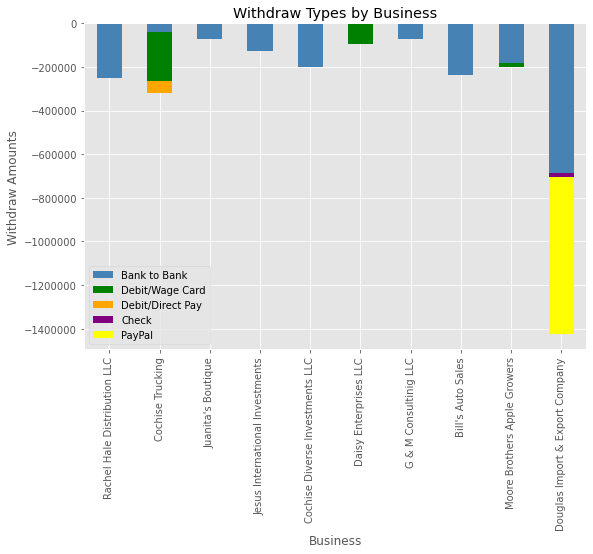

In [1717]:
#TODO -- GRAPH METHODS by account using stacked bar chart


#set seaborn plotting aesthetics
# sns.set(style='white')

#create stacked bar chart
# df.set_index('Day').plot(kind='bar', stacked=True, color=['steelblue', 'red'])


test = amount_df[['Business', 'type', 'Actual', 'Method']].copy()

#calculate totals for 'Entity', 'type', 'Method' groupby
test['Amount'] = test.groupby(['Business', 'type', 'Method'])['Actual'].transform(lambda x: x.sum())
test = test[['Business', 'type', 'Amount', 'Method']].drop_duplicates().reset_index(drop=True)
test


withdraw_df = test.loc[test.type == 'withdraw'][['Business', 'Amount', 'Method']].reset_index(drop=True)
min_y = withdraw_df.Amount.min()

def explode_columns(df):
    for i in df.Method.unique().tolist():
        df[i] = df.loc[df.Method == i]['Amount'].astype(float)
        df[i] = df[i].fillna(method='ffill')
        df[i] = df[i].fillna(method='bfill')
        df.drop_duplicates().reset_index(drop=True)
    return df

withdraw_df = pd.concat([explode_columns(withdraw_df.loc[withdraw_df.Business == i])\
    for i in withdraw_df.Business.unique().tolist()])
withdraw_df = withdraw_df.drop(['Amount','Method'], axis=1)
withdraw_df.fillna(0, inplace=True)
withdraw_df = withdraw_df.drop_duplicates().reset_index(drop=True)

withdraw_df.set_index('Business').plot(kind='bar', stacked=True, color=['steelblue', 'green', 'orange', 'purple', 'yellow'], figsize=(9,6))

# Add Title and Labels
plt.ticklabel_format(axis="y", style='plain')
plt.title('Withdraw Types by Business')
plt.xlabel('Business')
plt.ylabel('Withdraw Amounts')
plt.show()



/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/3167946130.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/3167946130.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/k5/xj06gf6908j4jcqqknyky3fc0000gp/T/ipykernel_28577/3167946130.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

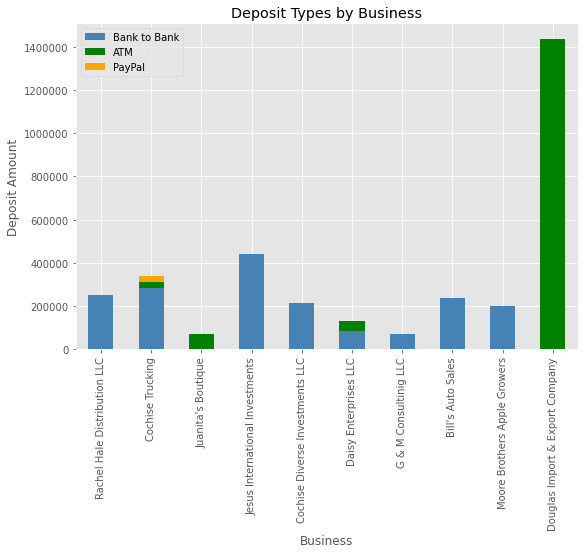

In [1718]:
deposit_df = test.loc[test.type == 'deposit'][['Business', 'Amount', 'Method']].reset_index(drop=True)

def explode_columns(df):
    for i in df.Method.unique().tolist():
        df[i] = df.loc[df.Method == i]['Amount']
        df[i] = df[i].fillna(method='ffill')
        df[i] = df[i].fillna(method='bfill')
        df.drop_duplicates().reset_index(drop=True)
    return df

deposit_df = pd.concat([explode_columns(deposit_df.loc[deposit_df.Business == i])\
    for i in deposit_df.Business.unique().tolist()])
deposit_df = deposit_df.drop(['Amount','Method'], axis=1)
deposit_df.fillna(0, inplace=True)
deposit_df = deposit_df.drop_duplicates().reset_index(drop=True)

deposit_df.set_index('Business').plot(kind='bar', stacked=True, color=['steelblue', 'green', 'orange', 'purple', 'yellow'], figsize=(9,6))

# Add Title and Labels
plt.ticklabel_format(axis="y", style='plain')
plt.title('Deposit Types by Business')
plt.xlabel('Business')
plt.ylabel('Deposit Amount')
plt.show()



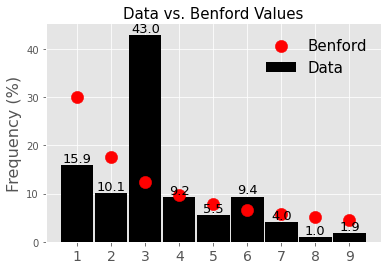


Chi-squared Test Statistic = 631.312
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


(693,
 [110, 70, 298, 64, 38, 65, 28, 7, 13],
 [15.873015873015872,
  10.1010101010101,
  43.001443001443,
  9.235209235209235,
  5.483405483405483,
  9.37950937950938,
  4.040404040404041,
  1.0101010101010102,
  1.875901875901876],
 "Breaks Bedford's Law.")

In [1862]:
#BENFORD'S LAW
#https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8


def bedford(df, amount_col, entity_col=False):
    #Benford percentages 1-9
    BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]
    
    def count_first_digit(df, amount_col):
        #get first digits
        mask=df[amount_col]>=1
        data=list(df[mask][amount_col])
        first_digits=[int(str(x)[0]) for x in sorted(data)]
        
        #need to fill null values... if there are no '8's, the percentage needs to be zero
        unique = set([i for i in range(1, 10)]) 
        #calculate percentages
        data_count=[]
        for i in unique:
            count=first_digits.count(i)
            data_count.append(count)
        total_count=sum(data_count)
        data_percentage=[(i/total_count)*100 for i in data_count]
        
        
        return  data, first_digits, total_count, data_count, data_percentage

    data, first_digits, total_count, data_count, data_percentage = count_first_digit(df, amount_col)
    
    #1st_bar_chart
    def bar_chart(data_pct):

        """Make bar chart of observed vs expected 1st digit frequency in percent."""
        fig, ax = plt.subplots()

        index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis
        
        # text for labels, title and ticks
        if entity_col != False:
            entity_name = df[entity_col].iloc[0]
            ax.set_title(f'{entity_name} Data vs. Benford Values', fontsize=15)
        else:
            ax.set_title(f'Data vs. Benford Values', fontsize=15)    
        ax.set_ylabel('Frequency (%)', fontsize=16)
        ax.set_xticks(index)
        ax.set_xticklabels(index, fontsize=14)


        # build bars    
        rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')

        # attach a text label above each bar displaying its height
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height,
                    '{:0.1f}'.format(height), ha='center', va='bottom', 
                    fontsize=13)

        # plot Benford values as red dots      
        ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')

        # Hide the right and top spines & add legend
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(prop={'size':15}, frameon=False)
        plt.show()
        
    bar_chart(data_percentage)


    def get_expected_counts(total_count):
        """Return list of expected Benford's Law counts for total sample count."""
        return [round(p * total_count / 100) for p in BENFORD]

    expected_counts=get_expected_counts(total_count)

    def chi_square_test(data_count,expected_counts):
        """Return boolean on chi-square test (8 degrees of freedom & P-val=0.05)."""
        try:
            chi_square_stat = 0  # chi square test statistic
            for data, expected in zip(data_count,expected_counts):
                chi_square = math.pow(data - expected, 2)
                chi_square_stat += chi_square / expected
        except:
            print('Sample size not large/diverse enough to aquire P-value.')
            
            pass
        print("\nChi-squared Test Statistic = {:.3f}".format(chi_square_stat))
        print("Critical value at a P-value of 0.05 is 15.51.")    
        if chi_square_stat < 15.51:
            print("Observed distribution MATCHES expected distribution using Bedford's Law.")
            answer = "Follows Bedford's Law."
        
        else:
            print("Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.")
            answer = "Breaks Bedford's Law."
    
        return  total_count, data_count, data_percentage, answer
            
    return chi_square_test(data_count,expected_counts)


bedford(amount_df, 'Amount')

In [ ]:
amount_df

,Date,From_Acct,From_Bank,To_Acct,To_Bank,Amount,To_Location,Account,type,Bank,Business,Owner,Full_To_Account,Full_From_Account,Month,Entity,Actual,Monthly_Total_USD,Method,Bedford
0,2030-02-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC",02,Rachel Hale Distribution LLC: Rachel Hale,"-60,000.00","-60,000.00",Bank to Bank,
1,2030-03-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC",03,Rachel Hale Distribution LLC: Rachel Hale,"-60,000.00","-60,000.00",Bank to Bank,
2,2030-04-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,60000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC",04,Rachel Hale Distribution LLC: Rachel Hale,"-60,000.00","-60,000.00",Bank to Bank,
3,2030-05-01 00:00:00,BF2339696,Butterfield Bank,7899940,Bueno Cambio Ex,70000,,BF2339696,withdraw,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Bueno Cambio Exchange,Jesus International Inve...","Butterfield Bank,Rachel Hale Distribution LLC",05,Rachel Hale Distribution LLC: Rachel Hale,"-70,000.00","-70,000.00",Bank to Bank,
4,2030-02-01 00:00:00,W4567288,WSFS Bank,BF2339696,Butterfield Bank,45000,,BF2339696,deposit,Butterfield Bank,Rachel Hale Distribution LLC,Rachel Hale,"Butterfield Bank,Rachel Hale Distribution LLC","WSFS Bank,G & M Consultinig LLC",02,Rachel Hale Distribution LLC: Rachel Hale,"45,000.00","60,000.00",Bank to Bank,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2030-04-30 00:00:00,1235551,Wells Fargo Bank,(Check) Fuel,Good 2 Go Gas,45,Fuel,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Fuel: Good 2 Go Gas,"Wells Fargo Bank,Douglas Import & Export Company",04,Douglas Import & Export Company: Yasmine Badr...,-45.00,"-351,330.13",Check,
689,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Payroll,Yasmine Badreddine,3000,Payroll,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Payroll: Yasmine Badreddine,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,"-3,000.00","-419,000.24",Check,
690,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Rent & Utilities,Raul Zapata,400,Rent & Utilities,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Rent & Utilities: Raul Zapata,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,-400.00,"-419,000.24",Check,
691,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Mailing & Postage,Cash,650,Mailing & Postage,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Mailing & Postage: Cash,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,-650.00,"-419,000.24",Check,


Cochise Diverse Investments LLC


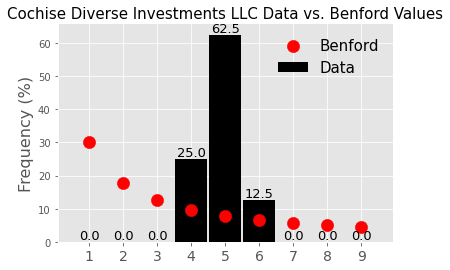

Sample size not large/diverse enough to aquire P-value.

Chi-squared Test Statistic = 21.000
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


(8,
 [0, 0, 0, 2, 5, 1, 0, 0, 0],
 [0.0, 0.0, 0.0, 25.0, 62.5, 12.5, 0.0, 0.0, 0.0],
 "Breaks Bedford's Law.")

In [ ]:


def count_first_digit(df, amount_col):
    #get first digits
    mask=df[amount_col]>=1
    data=list(df[mask][amount_col])
    first_digits=[int(str(x)[0]) for x in sorted(data)]
    unique=(set(first_digits))  #a list with unique values of first_digit list
    
    #need to fill null values... if there are no '8's, the percentage needs to be zero
    unique = set([i for i in range(1, 10)])    
    #calculate percentages
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    
    
    return  unique, data, first_digits, total_count, data_count, data_percentage


# data, first_digits, total_count, data_count, data_percentage = count_first_digit(df, amount_col)

acount_list = amount_df.Business.unique().tolist()
print(acount_list[4])
bedford(amount_df[amount_df.Business == acount_list[4]], 'Amount', 'Business')


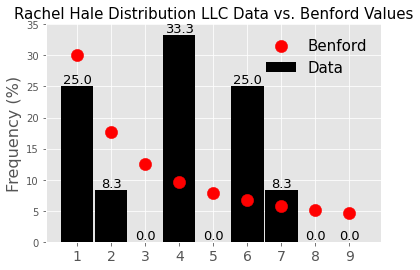


Chi-squared Test Statistic = 18.750
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


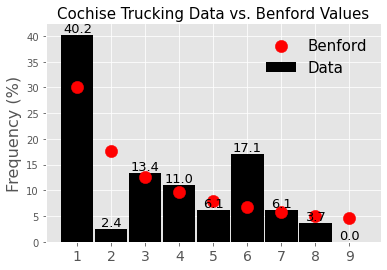


Chi-squared Test Statistic = 33.687
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


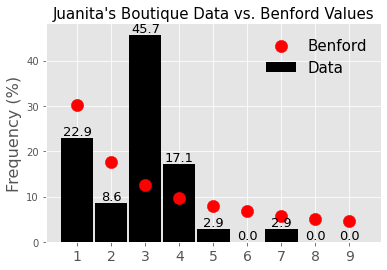


Chi-squared Test Statistic = 49.152
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


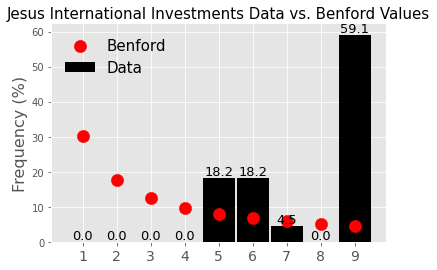


Chi-squared Test Statistic = 172.000
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


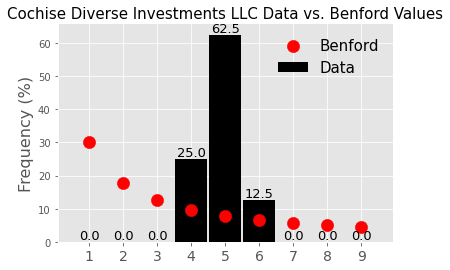

Sample size not large/diverse enough to aquire P-value.

Chi-squared Test Statistic = 21.000
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


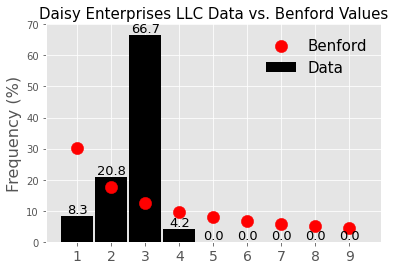


Chi-squared Test Statistic = 67.655
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


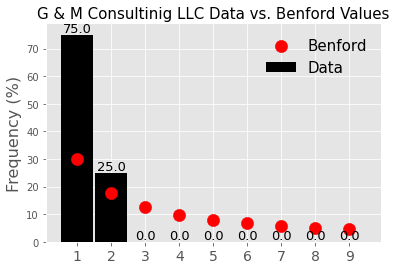

Sample size not large/diverse enough to aquire P-value.

Chi-squared Test Statistic = 13.000
Critical value at a P-value of 0.05 is 15.51.
Observed distribution MATCHES expected distribution using Bedford's Law.


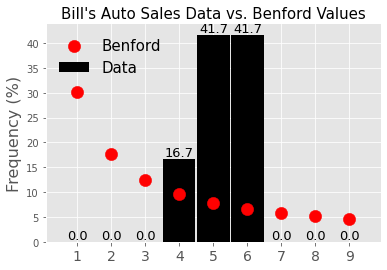


Chi-squared Test Statistic = 44.000
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


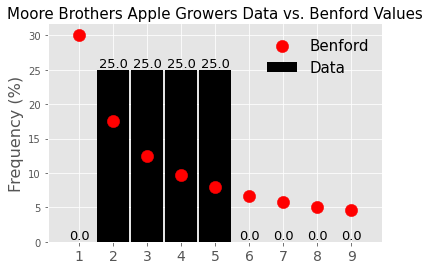


Chi-squared Test Statistic = 22.333
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


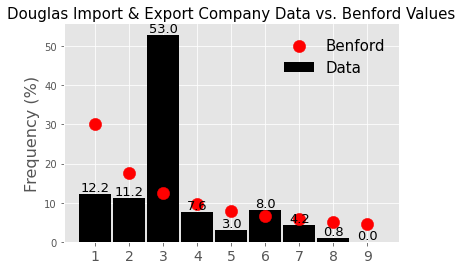


Chi-squared Test Statistic = 744.259
Critical value at a P-value of 0.05 is 15.51.
Observed distribution DOES NOT MATCH expected distribution using Bedford's Law.


,0,1,2,3
BF2339696,12,"[3, 1, 0, 4, 0, 3, 1, 0, 0]","[25.0, 8.333333333333332, 0.0, 33.333333333333...",Breaks Bedford's Law.
2342298,82,"[33, 2, 11, 9, 5, 14, 5, 3, 0]","[40.243902439024396, 2.4390243902439024, 13.41...",Breaks Bedford's Law.
1235550,35,"[8, 3, 16, 6, 1, 0, 1, 0, 0]","[22.857142857142858, 8.571428571428571, 45.714...",Breaks Bedford's Law.
7899940,22,"[0, 0, 0, 0, 4, 4, 1, 0, 13]","[0.0, 0.0, 0.0, 0.0, 18.181818181818183, 18.18...",Breaks Bedford's Law.
CF2331210,8,"[0, 0, 0, 2, 5, 1, 0, 0, 0]","[0.0, 0.0, 0.0, 25.0, 62.5, 12.5, 0.0, 0.0, 0.0]",Breaks Bedford's Law.
2342296,24,"[2, 5, 16, 1, 0, 0, 0, 0, 0]","[8.333333333333332, 20.833333333333336, 66.666...",Breaks Bedford's Law.
W4567288,8,"[6, 2, 0, 0, 0, 0, 0, 0, 0]","[75.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Follows Bedford's Law.
K5679021,12,"[0, 0, 0, 2, 5, 5, 0, 0, 0]","[0.0, 0.0, 0.0, 16.666666666666664, 41.6666666...",Breaks Bedford's Law.
B3454649,16,"[0, 4, 4, 4, 4, 0, 0, 0, 0]","[0.0, 25.0, 25.0, 25.0, 25.0, 0.0, 0.0, 0.0, 0.0]",Breaks Bedford's Law.
1235551,474,"[58, 53, 251, 36, 14, 38, 20, 4, 0]","[12.236286919831224, 11.181434599156118, 52.95...",Breaks Bedford's Law.


In [1864]:
bedford_dict={}
for account in amount_df.Account.unique().tolist():
    loop_df = amount_df[amount_df.Account == account]
    bedford_dict[account] = bedford(loop_df, 'Amount', 'Business')

bedford_df = pd.DataFrame.from_dict(bedford_dict, orient ='index')
bedford_df


In [ ]:
#1st_bar_chart
def bar_chart(data_pct):

    """Make bar chart of observed vs expected 1st digit frequency in percent."""

    fig, ax = plt.subplots()



    index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis
# text for labels, title and ticks

    fig.canvas.set_window_title('Percentage First Digits')

    ax.set_title('Data vs. Benford Values', fontsize=15)

    ax.set_ylabel('Frequency (%)', fontsize=16)

    ax.set_xticks(index)

    ax.set_xticklabels(index, fontsize=14)



    # build bars    

    rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')



    # attach a text label above each bar displaying its height

    for rect in rects:

        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2, height,

                '{:0.1f}'.format(height), ha='center', va='bottom', 

                fontsize=13)



    # plot Benford values as red dots

    ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')



    # Hide the right and top spines & add legend

    ax.spines['right'].set_visible(False)

    ax.spines['top'].set_visible(False)

    ax.legend(prop={'size':15}, frameon=False)

    

    plt.show()
    
    #2nd_bar_chart
    labels=list(data_percentage)
    width = 0.35 
    x = np.arange(len(data_percentage)) # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, data_percentage, width=0.95, color='black', label='Data')
    rects2 = ax.bar(x + width, BENFORD,width,label='Benford')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency (%)', fontsize=16)
    ax.set_title('Benford')
    ax.set_xticks(x)
    ax.legend()
    plt.show()


In [1748]:
amount_df[amount_df.Account == account]

,Date,From_Acct,From_Bank,To_Acct,To_Bank,Amount,To_Location,Account,type,Bank,Business,Owner,Full_To_Account,Full_From_Account,Month,Entity,Actual,Monthly_Total_USD,Method,Bedford
219,2030-02-01 00:00:00,1235551,Wells Fargo Bank,Auto WD,PayPal,80000,Juanita's Boutiques,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,Auto WD: PayPal,"Wells Fargo Bank,Douglas Import & Export Company",02,Douglas Import & Export Company: Yasmine Badr...,"-80,000.00","-325,009.14",PayPal,
220,2030-02-01 00:00:00,1235551,Wells Fargo Bank,Divx Computers,PayPal,100000,Divx Computers,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,Divx Computers,"Wells Fargo Bank,Douglas Import & Export Company",02,Douglas Import & Export Company: Yasmine Badr...,"-100,000.00","-325,009.14",PayPal,
221,2030-02-01 00:00:00,1235551,Wells Fargo Bank,B3454649,Banner Bank,50000,Moore Brothers,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,"Banner Bank,Moore Brothers Apple Growers","Wells Fargo Bank,Douglas Import & Export Company",02,Douglas Import & Export Company: Yasmine Badr...,"-50,000.00","-325,009.14",Bank to Bank,
222,2030-02-01 00:00:00,1235551,Wells Fargo Bank,W4567288,WSFS Bank,15000,G&M Consulting,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,"WSFS Bank,G & M Consultinig LLC","Wells Fargo Bank,Douglas Import & Export Company",02,Douglas Import & Export Company: Yasmine Badr...,"-15,000.00","-325,009.14",Bank to Bank,
223,2030-02-01 00:00:00,1235551,Wells Fargo Bank,K5679021,Key Bank,"55,189.91",Bill's Auto Sales,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,"Key Bank,Bill's Auto Sales","Wells Fargo Bank,Douglas Import & Export Company",02,Douglas Import & Export Company: Yasmine Badr...,"-55,189.91","-325,009.14",Bank to Bank,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2030-04-30 00:00:00,1235551,Wells Fargo Bank,(Check) Fuel,Good 2 Go Gas,45,Fuel,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Fuel: Good 2 Go Gas,"Wells Fargo Bank,Douglas Import & Export Company",04,Douglas Import & Export Company: Yasmine Badr...,-45.00,"-351,330.13",Check,
689,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Payroll,Yasmine Badreddine,3000,Payroll,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Payroll: Yasmine Badreddine,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,"-3,000.00","-419,000.24",Check,
690,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Rent & Utilities,Raul Zapata,400,Rent & Utilities,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Rent & Utilities: Raul Zapata,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,-400.00,"-419,000.24",Check,
691,2030-05-31 00:00:00,1235551,Wells Fargo Bank,(Check) Mailing & Postage,Cash,650,Mailing & Postage,1235551,withdraw,Wells Fargo Bank,Douglas Import & Export Company,Yasmine Badreddine,(Check) Mailing & Postage: Cash,"Wells Fargo Bank,Douglas Import & Export Company",05,Douglas Import & Export Company: Yasmine Badr...,-650.00,"-419,000.24",Check,
